In [1]:
!pip install GPUtil

  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=b36276bbc4d19890c6354455170c9668a6a0f251a2cd864208b3c5312b5c115f
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil


In [2]:
import pandas as pd
import numpy as np
import gc
from GPUtil import showUtilization as gpu_usage
from numba import cuda

#para imagenes
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

#para la validacion
from sklearn.model_selection import train_test_split

#para evaluar el modelo
from sklearn.metrics import accuracy_score
from tqdm import tqdm

#pytorch
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!unzip gdrive/My\ Drive/TopicosIA/2021-2/ProyectoTopIAFinal/Data/train_LbELtWX

Se truncaron las últimas líneas 5000 del resultado de transmisión.
 extracting: train/45712.png         
 extracting: train/57389.png         
 extracting: train/5260.png          
 extracting: train/58492.png         
 extracting: train/58143.png         
 extracting: train/616.png           
 extracting: train/25467.png         
 extracting: train/37219.png         
 extracting: train/55151.png         
 extracting: train/57860.png         
 extracting: train/22627.png         
 extracting: train/52644.png         
 extracting: train/45879.png         
 extracting: train/33451.png         
 extracting: train/23972.png         
 extracting: train/38967.png         
 extracting: train/38753.png         
 extracting: train/33900.png         
 extracting: train/50011.png         
 extracting: train/1922.png          
 extracting: train/5638.png          
 extracting: train/37358.png         
 extracting: train/6609.png          
 extracting: train/6492.png          
 extracting: train/36

In [5]:
train = pd.read_csv('train.csv')

train.head()

,id,label
0,1,9
1,2,0
2,3,0
3,4,3
4,5,0


In [6]:
#cargar imagenes de entrenamiento

train_img = []

for img_name in tqdm(train['id']):
  #path de las imagenes
  image_path = 'train/' + str(img_name) + '.png'
  #leer la imagen
  img = imread(image_path, as_gray = True)
  #normalizando los valores de los pixeles
  img /= 255.0
  #convertir el tipo de pixel a un float de 32 bits
  img = img.astype('float32')
  #añadirlo a la lista
  train_img.append(img)

#convertir la lista a numpy
X_train = np.array(train_img)
#definir los labels
Y_train = train['label'].values
X_train.shape


100%|██████████| 60000/60000 [00:46<00:00, 1278.17it/s]


(60000, 28, 28)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4e8916d790>,
 <matplotlib.image.AxesImage at 0x7f4e8afa88d0>)

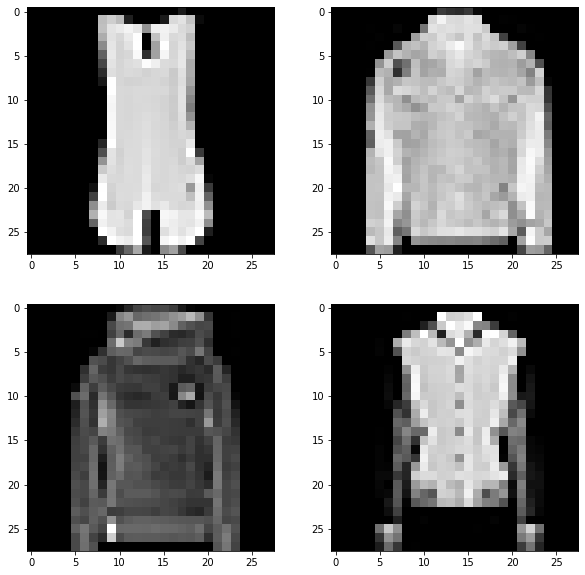

In [7]:
#mostrar algunas de las imagenes en la lista
plt.figure(figsize = (10,10))
plt.subplot(221), plt.imshow(X_train[4], cmap = 'gray')
plt.subplot(222), plt.imshow(X_train[29], cmap = 'gray')
plt.subplot(223), plt.imshow(X_train[54], cmap = 'gray')
plt.subplot(224), plt.imshow(X_train[76], cmap = 'gray')

In [8]:
#crear un conjunto de datos para el test, primero se utilizará el test por defecto
#luego se probará con datos propios

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.3)
#70 training, 30 testing
X_train.shape,Y_train.shape, X_test.shape, Y_test.shape

((42000, 28, 28), (42000,), (18000, 28, 28), (18000,))

In [9]:
#convertir las imagenes a formato torch
X_train = X_train.reshape(42000,1,28,28)
X_train = torch.from_numpy(X_train)

Y_train = Y_train.astype(int)
Y_train = torch.from_numpy(Y_train)

X_train.shape, Y_train.shape


(torch.Size([42000, 1, 28, 28]), torch.Size([42000]))

In [10]:
#convertir las imagenes a formato torch
X_test = X_test.reshape(18000,1,28,28)
X_test = torch.from_numpy(X_test)

Y_test = Y_test.astype(int)
Y_test = torch.from_numpy(Y_test)

X_test.shape, Y_test.shape

(torch.Size([18000, 1, 28, 28]), torch.Size([18000]))

In [11]:
#definir la arquitectura

#dos capas convolucionales para extraer las caracteristicas de las imagenes
#una capa densa totalmente conectada para clasificar dichas caracteristicas en sus respectivas categorias

class Net(Module):
  def __init__(self):
    super(Net, self).__init__()

    self.cnn_layers = Sequential(
      #Definir las capas convolucionales
      #(W-F+2P)/S +1
      Conv2d(1, 4, kernel_size = 3, stride = 1, padding = 1), #(28-3+2*1)/1 + 1 = 28
      BatchNorm2d(4),
      ReLU(inplace = True), #inplace es más amigable con la memoria
      #(W-F)/S +1
      MaxPool2d(kernel_size = 2, stride = 2), # (28-2)/2 + 1 = 14

      Conv2d(4, 4, kernel_size = 3, stride = 1, padding = 1), #(14-3+2*1)/1 + 1 =14
      BatchNorm2d(4),
      ReLU(inplace = True),
      MaxPool2d(kernel_size = 2, stride = 2), # (14-2)/2 +1 = 7
    )
    self.linear_layers = Sequential(
      Linear(4 * 7 * 7, 10) # canales de salida, por las dimensiones de la imagen
    )
  def forward(self, x):
    x = self.cnn_layers(x)
    x = x.view(x.size(0),-1)
    x = self.linear_layers(x)
    return x


In [12]:
#definir el modelo
model = Net()
#definir el optimizador
optimizer = Adam(model.parameters(), lr=0.0001)
#definir función de costo
costfunc = CrossEntropyLoss()
#usar CUDA
if torch.cuda.is_available():
  model = model.cuda()
  costfunc = costfunc.cuda()

print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


In [13]:
def train(epochs):
  gc.collect()
  torch.cuda.empty_cache()
  model.train()
  tr_cost=0
  #el conjunto de entrenamiento
  x_train, y_train = Variable(X_train), Variable(Y_train)
  #conjunto de testing
  x_test, y_test = Variable(X_test), Variable(Y_test)
  #convertir la data a formato de CUDA
  if torch.cuda.is_available():
    x_train = x_train.cuda()
    y_train = y_train.cuda()
    x_test = x_test.cuda()
    y_test = y_test.cuda()
  #volver cero el gradiente de los parametros
  optimizer.zero_grad()

  #prediccion
  train_pred = model(x_train)
  test_pred = model(x_test)

  #obtención del costo
  train_cost = costfunc(train_pred, y_train)
  test_cost = costfunc(test_pred, y_test)

  train_costs.append(train_cost.item())
  test_costs.append(test_cost.item())

  #actualización de pesos del modelo
  train_cost.backward()
  optimizer.step()
  
  tr_cost=train_cost.item()
  if epochs%2 == 0:
    print('Epoch: ', epochs+1,' ', 'Costo: ', test_cost)
  return train_cost.item()

In [14]:
def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()


In [15]:
#entrenamiento del modelo
n_epochs = 1000

train_costs = []
test_costs = []

model.zero_grad()

for epoch in range(n_epochs):
    train(epoch)
    


Epoch:  1   Costo:  tensor(2.5571, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch:  3   Costo:  tensor(2.5397, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch:  5   Costo:  tensor(2.5226, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch:  7   Costo:  tensor(2.5058, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch:  9   Costo:  tensor(2.4894, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch:  11   Costo:  tensor(2.4734, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch:  13   Costo:  tensor(2.4576, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch:  15   Costo:  tensor(2.4422, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch:  17   Costo:  tensor(2.4271, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch:  19   Costo:  tensor(2.4123, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch:  21   Costo:  tensor(2.3979, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch:  23   Costo:  tensor(2.3836, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch:  25   Costo:  tensor(2.369

In [16]:
gpu_usage()
torch.cuda.empty_cache()
torch.cuda.empty_cache()

| ID | GPU | MEM |
------------------
|  0 | 77% | 42% |


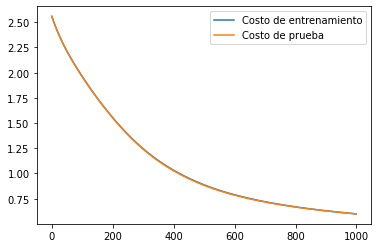

In [17]:
#El costo del training y del testing
plt.plot(train_costs, label='Costo de entrenamiento')
plt.plot(test_costs, label='Costo de prueba')
plt.legend()
plt.savefig('/content/gdrive/MyDrive/TopicosIA/2021-2/ProyectoTopIAFinal/Data/test_propio/losses.png')
plt.show()

In [18]:
def set_accuracy(x,y):
  with torch.no_grad():
    output = model(x.cuda())

  softmax = torch.exp(output).cpu()
  prob = list(softmax.numpy())
  predictions = np.argmax(prob, axis=1)
  return accuracy_score(y, predictions)

In [19]:
#precisión del conjunto de entrenamiento
print(set_accuracy(X_train,Y_train),'\n')
#precisión del conjunto de entrenamiento
print(set_accuracy(X_test,Y_test))

#el primer test tuvo un buen resultado de 81%

0.8087619047619048 

0.8092222222222222


In [20]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

  0%|          | 0/16 [00:00<?, ?it/s]

(28, 28)


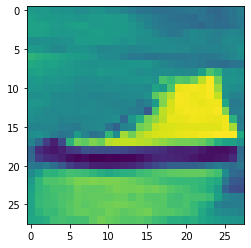

  6%|▋         | 1/16 [00:01<00:22,  1.49s/it]

(28, 28)


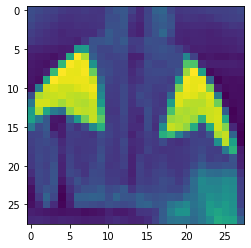

 12%|█▎        | 2/16 [00:02<00:20,  1.48s/it]

(28, 28)


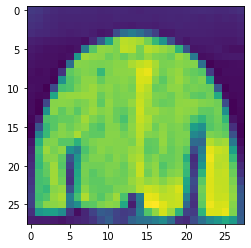

 19%|█▉        | 3/16 [00:04<00:18,  1.39s/it]

(28, 28)


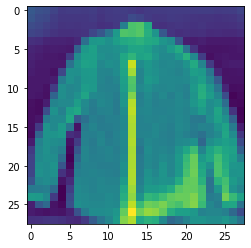

 25%|██▌       | 4/16 [00:05<00:16,  1.37s/it]

(28, 28)


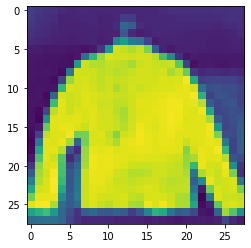

 31%|███▏      | 5/16 [00:06<00:14,  1.31s/it]

(28, 28)


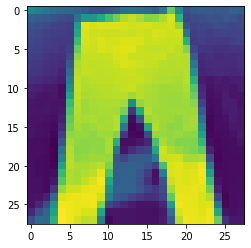

 38%|███▊      | 6/16 [00:08<00:13,  1.32s/it]

(28, 28)


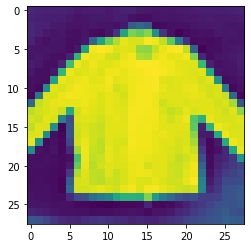

 44%|████▍     | 7/16 [00:09<00:11,  1.24s/it]

(28, 28)


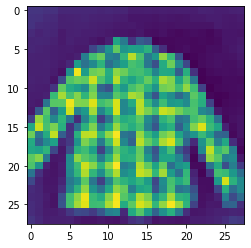

 50%|█████     | 8/16 [00:10<00:10,  1.28s/it]

(28, 28)


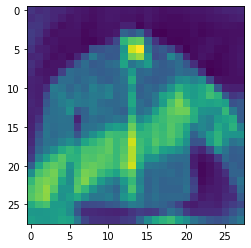

 56%|█████▋    | 9/16 [00:11<00:09,  1.30s/it]

(28, 28)


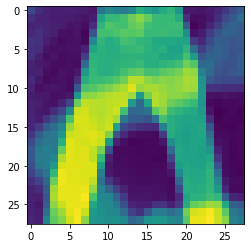

 62%|██████▎   | 10/16 [00:13<00:07,  1.32s/it]

(28, 28)


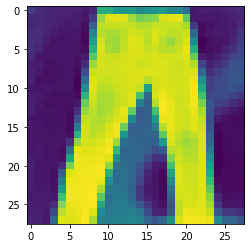

 69%|██████▉   | 11/16 [00:14<00:06,  1.28s/it]

(28, 28)


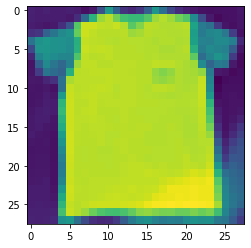

 75%|███████▌  | 12/16 [00:15<00:05,  1.26s/it]

(28, 28)


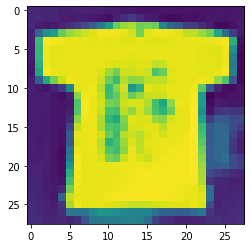

 81%|████████▏ | 13/16 [00:16<00:03,  1.25s/it]

(28, 28)


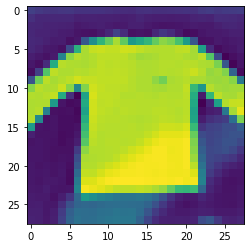

 88%|████████▊ | 14/16 [00:18<00:02,  1.22s/it]

(28, 28)


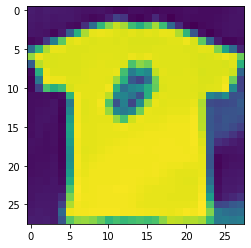

 94%|█████████▍| 15/16 [00:19<00:01,  1.21s/it]

(28, 28)


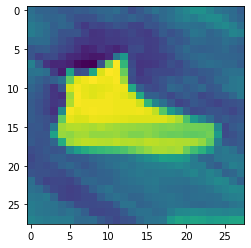

100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


(16, 28, 28)

In [21]:
import matplotlib.image as mpimg
from PIL import Image
import cv2

test = pd.read_csv('/content/gdrive/MyDrive/TopicosIA/2021-2/ProyectoTopIAFinal/Data/test_propio/test.csv')
sample_submission = pd.read_csv('/content/gdrive/MyDrive/TopicosIA/2021-2/ProyectoTopIAFinal/Data/test_propio/sample_submission.csv')



#Preparación para realizar el test

test_img = []

for img_name in tqdm(test['id']):
  #path de las imagenes
  image_path = '/content/gdrive/MyDrive/TopicosIA/2021-2/ProyectoTopIAFinal/Data/test_propio/' + str(img_name) + '.png'

  image = Image.open(image_path)
  image = image.resize((28,28))
  print(image.size)
  image_path = '/content/gdrive/MyDrive/TopicosIA/2021-2/ProyectoTopIAFinal/Data/test_images_edited/'  + str(img_name) + '.png'
  image = image.save(image_path)

  

  #lectura de las imagenes convertidas a escala de grises
  img = imread(image_path, as_gray = True)
  #conversion a negativo
  img = 1 - img
  #normalización de valores de pixeles
  img /= 255.0
  #conversión a float de 32 bits
  img = img.astype('float32')
  #se añaden las imagenes a una lista
  test_img.append(img)
  #mostrar imagen
  plt.imshow(img)
  plt.show()

#la lista se convierte a np array
X_test = np.array(test_img)
X_test.shape

In [22]:
#las imágenes de la segunda prueba se convierten en formato torch
X_test = X_test.reshape(16,1,28,28)
X_test = torch.from_numpy(X_test)
X_test.shape

torch.Size([16, 1, 28, 28])

In [23]:
#generación de las predicciones
with torch.no_grad():
  output = model(X_test.cuda())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis = 1)



In [24]:
#guardando las predicciones
sample_submission['label'] = predictions
sample_submission
#0 T-shirt/top 1 Trouser 2 Pullover 3 Dress 4 Coat 5 Sandal 
#6 Shirt 7 Sneaker 8 Bag 9 Ankle boot

,id;,label
0,1;,8
1,2;,8
2,3;,8
3,4;,6
4,5;,8
5,6;,2
6,7;,4
7,8;,8
8,9;,8
9,10;,2


In [25]:
sample_submission.to_csv('/content/gdrive/MyDrive/TopicosIA/2021-2/ProyectoTopIAFinal/Data/test_propio/submission.csv', index = False)